# Multifactorial immune response 
## Reproduction of training part 
This notebook is an educational reproduction of the training python code from the repository below. 
https://github.com/lrgr/multifactorial-immune-response The processed data used in the training are from the Snakemake flow of the original repo authors. 

In [1]:
import sys, os, argparse, logging, pandas as pd, numpy as np, json
from sklearn.model_selection import *
import matplotlib
#matplotlib.use('agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('whitegrid')

In [5]:
os.chdir('./multifactor-immune-response/')

In [6]:
import warnings
#warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

In [7]:
# Load the modules from (https://github.com/lrgr/multifactorial-immune-response)
from models import MODEL_NAMES, init_model, RF, EN, FEATURE_CLASSES, IMPORTANCE_NAMES, FEATURE_CLASS_NAMES
from metrics import compute_metrics, RMSE, MAE, MSE
from i_o import getLogger

/home/shawnagie/anaconda3/envs/mldl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/shawnagie/anaconda3/envs/mldl/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
# define file locations
processed_features = './data/snyder_et_al_processed_data-features.tsv'
processed_feature_classes = './data/snyder_et_al_processed_data-feature-classes.tsv'
processed_outcomes = './data/snyder_et_al_processed_data-outcomes.tsv'

In [9]:
# Loading the input data
X = pd.read_csv(processed_features, index_col=0, sep='\t')
y = pd.read_csv(processed_outcomes, index_col=0, sep='\t')
feature_classes = pd.read_csv(processed_feature_classes, index_col=0, sep='\t')

In [10]:
# Align the features and outcomes
patients = X.index
X = X.reindex(index = patients)
y = y.reindex(index = patients)
outcome_name = y.columns[0]

In [11]:
# Create json structure to hold output 
json_output = dict(patients=list(map(float, patients)))

In [12]:
# Training model on all data 
selected_feature_classes = set(map(str.capitalize, set(FEATURE_CLASSES) ))
training_cols = feature_classes.loc[feature_classes['Class'].isin(selected_feature_classes)].index.tolist()


In [13]:
# parameter selection (refer to /config/default.yml of the original repo)
# ElasticNet, number of worker = 12, random seed, max interation and tol
pipeline, gscv = init_model('en', 12, 2019, 5000000, 1e-7)

In [14]:
# LeaveOneOut cross validation will be used 
outer_cv = LeaveOneOut()
preds = pd.Series(cross_val_predict(estimator = gscv,
                                   X=X.loc[:,training_cols],
                                    y=y[outcome_name], cv=outer_cv,
                                    n_jobs = 12,
                                    verbose=0 ),
                 index = patients)


In [16]:
# subset prediction/true value 
sub_y = y.loc[patients][outcome_name].values
sub_preds = preds.loc[patients].values
metric_vals, var_explained = compute_metrics(sub_y, sub_preds)
rmses = metric_vals[RMSE]
mses = metric_vals[MSE]
maes = metric_vals[MAE]

In [17]:
# comparing hold-out RMSE to baseline RMSE from prediction
print('[Held-out RMSE, Baseline RMSE]: {}'.format([rmses['held-out'], rmses['baseline']]))
print('[Held-out MSE, Baseline MSE]: {}'.format([mses['held-out'], mses['baseline']]))
print('[Held-out MAE, Baseline MAE]: {}'.format([maes['held-out'], maes['baseline']]))
print('Variance explained: {}'.format(var_explained))

[Held-out RMSE, Baseline RMSE]: [0.4195884075047284, 0.9154967187613872]
[Held-out MSE, Baseline MSE]: [0.17605443171235405, 0.8381342420628665]
[Held-out MAE, Baseline MAE]: [0.4195884075047284, 0.9154967187613872]
Variance explained: 0.7899448287913422


In [18]:
# record JSON output 
json_output.update({
    "preds": sub_preds.tolist(),
    "true": sub_y.tolist(),
    "variance_explained": var_explained,
    "rmse": rmses,
    "mse": mses,
    "mae": maes
})

In [19]:
# evaluate feature importance 
pipeline.named_steps['estimator'].set_params(verbose=1)
model = pipeline.fit(X.loc[:,training_cols], y[outcome_name])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [20]:
# coefficient importance with all variables on the same scale 
variable_scores = model.named_steps['estimator'].coef_ * X.loc[:,training_cols].fillna(X.loc[:,training_cols].median()).std()
variable_scores = pd.Series(variable_scores, index = X.loc[:, training_cols].columns, name='Score')

In [21]:
# Associate feature classes with scores
variable_scores = pd.concat([variable_scores, feature_classes], axis = 1)

# Sort scores by importance magnitude
variable_scores = variable_scores.reindex(variable_scores['Score'].abs().sort_values(ascending=False).index)

# Output a pretty summary of feature importances
var_importance_tbl = variable_scores.to_string()
rows = var_importance_tbl.split('\n')


In [22]:
# Output plot data to JSON
with open('training-results.json', 'w') as OUT:
    json.dump( json_output, OUT )

# Output results summary to TSV
variable_scores.to_csv('feature_coefficients.tsv', sep='\t', index=True)

In [23]:
variable_scores.head()

,Score,Class
#Feature name,,
expressed_neoantigen_count,0.693888,Tumor
log_neoantigen_count,-0.627353,Tumor
Top Clone Freq(%),0.531470,Blood
Time since last chemotherapy,-0.529836,Clinical
Age,-0.520986,Clinical


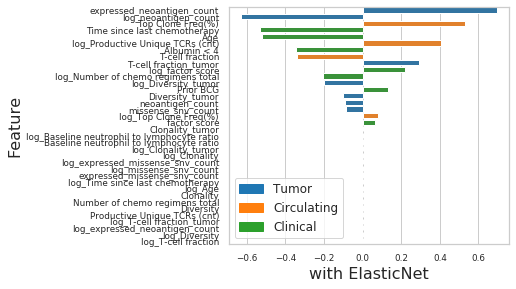

In [24]:
# visualizating important fetures 
var_importance = variable_scores
var_importance = var_importance.reset_index()
var_importance_name = 'with ElasticNet'
var_importance = var_importance.rename(index=str, columns={"#Feature name": "Feature", "Score": var_importance_name})
var_importance['Class'] = var_importance['Class'].map({fc.capitalize(): fcn for fc, fcn in FEATURE_CLASS_NAMES.items() })

#
classToColor = dict(zip(['Tumor', 'Circulating', 'Clinical'], sns.color_palette()[:3]))
featureToImportance = dict(zip(var_importance['Feature'], var_importance[var_importance_name]))
featureToClass = dict(zip(var_importance['Feature'], var_importance['Class']))

features = sorted(var_importance['Feature'], key=lambda f: abs(featureToImportance[f]), reverse=True)
classes = [ featureToClass[f] for f in features ]
palette = [ classToColor[c] for c in classes ]
sns.set(font_scale=0.8, style='whitegrid')  # smaller
ax = sns.barplot(x=var_importance_name, y="Feature", data=var_importance,
           label=var_importance_name, palette=palette, order=features)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)

# Add custom legend
patches = [ mpatches.Patch(color=col, label=c) for c, col in classToColor.items() ]
plt.legend(handles=patches, fontsize=12)

# Output to file
plt.subplots_adjust(left=0.3, right=0.95, top=0.95)

plt.show()